In [187]:
!pip3 install dsd==0.0.1

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, diags
import networkx as nx
import random 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import dsd

In [67]:
n=30
#G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
G=nx.scale_free_graph(n, alpha=0.09, beta=0.9, gamma=0.01, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
#G=nx.erdos_renyi_graph(n,0.5)
nx.Graph(G)
print(len(G.edges))

215


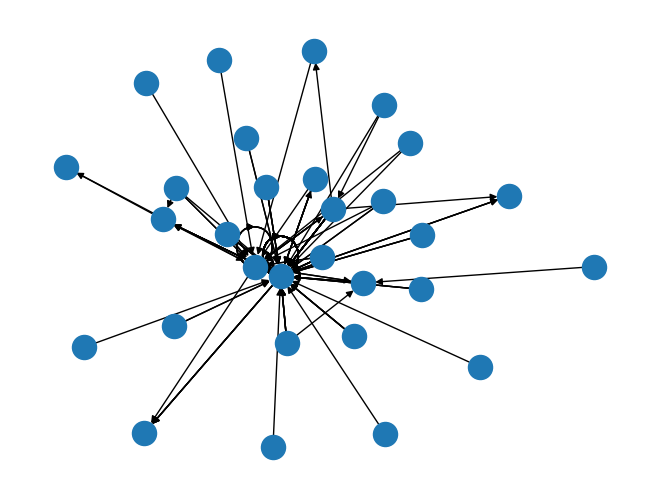

In [69]:
nx.draw(G)

In [4]:
def prune_graphlinks(netw):
    while True :
        l=[]
        #print(netw.number_of_nodes())
        for i in netw.nodes():
            if netw.degree[i]<=1:
                l.append(i)
        assert (netw.inflow not in l) and (netw.outflow not in l) 
        if l:
            #print(l)
            netw.remove_nodes_from(l)
        else:
            break

def get_flow(netw):
    """
    Returns the matrix of fluxes M and flow potentials F.
    
    An alternative of the following code is to compute the Laplacian matrix
    using the built-in L = laplacian(G) function. However, for small networks
    (i.e. N0 < 1600), this code seems faster.
    (need further investigations for assessing runtime differences).
    """
    prune_graphlinks(netw)
    
    
    # Preallocs:
    #sized = netw.graph.Nodes.shape[0]
    sized = netw.number_of_nodes()
    
    # For Matlab 'graph' adaptation, just re-create the adjacency matrix:
    netw.adjm = nx.adjacency_matrix(netw).todense()
    netw.adjm[netw.adjm > 1] = 1
    
    
    # Use Python version:
    P, S = prepare_linsys(netw, sized)
    
    # Remove both inflow and outflow entries from P:
    #P = np.delete(np.delete(P, netw.inflow, 0), netw.inflow, 1)
    P = np.delete(np.delete(P, netw.outflow, 0), netw.outflow, 1)
    #S = np.delete(S, [netw.inflow, netw.outflow])
    S = np.delete(S, [netw.outflow])
    
    # Solve the linear system:
    FF = np.linalg.solve(P, S)
    # Re-insert inflow and outflow nodes:
    F = np.zeros(sized)
    #F[:min([netw.inflow, netw.outflow])-1] = FF[:min([netw.inflow, netw.outflow])-1]
    #F[min([netw.inflow, netw.outflow])+1:max([netw.inflow, netw.outflow])-1] = FF[min([netw.inflow, netw.outflow]):max([netw.inflow, netw.outflow])-2]
    #F[max([netw.inflow, netw.outflow])+1:] = FF[max([netw.inflow, netw.outflow])-1:]
    F[1:]=FF[:]
    
    
    if min([netw.inflow, netw.outflow]) == netw.inflow:
        F[min([netw.inflow, netw.outflow])] = 1
        F[max([netw.inflow, netw.outflow])] = 0
    else:
        F[min([netw.inflow, netw.outflow])] = 0
        F[max([netw.inflow, netw.outflow])] = 1
    
    F = F.T
    
    # Then compute the fluxes matrix M, according to F (flow potentials):
    M = compute_q(netw, sized, F)
    
    return F, M

def compute_q(netw, sized, F):
    """
    Compute the fluxes matrix M, according to F (flow potentials).
    """
    M = np.zeros((sized, sized))
    
    for i in range(netw.adjm.shape[0]):
        #idx = netw.adjm[i] == 1
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        #D = netw.dis_eucl[i, idx]
        D=1
        for j in idx:
             M[i, j] = -(F[i] - F[j]) / D

    return M

def prepare_linsys(netw, sized):
    """
    Prepare the linear system for solving.
    """
    P = np.zeros((sized, sized))
    S = np.zeros(sized)
    nodes = list(netw.nodes())
    for i in range(netw.adjm.shape[0]):
        idx = [j for j in range(sized) if netw.adjm[i,j] == 1]
        
        for j in idx:
            P[i,j] = -1
        
        P[i,i]=len(idx)
     
    S[nodes.index(netw.inflow)]=1

    return P, S



In [136]:
def gen_graph(n):
    G=nx.erdos_renyi_graph(n,0.5)
    G.inflow=1
    G.outflow=0
    
    #G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    #G2 = G.to_undirected()
    #G2.remove_edges_from(nx.selfloop_edges(G2))
    
    return G
    #return G2

def gen_graph_scalefree(n):
    G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    #G=nx.scale_free_graph(n, alpha=0.09, beta=0.9, gamma=0.01, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    G2 = G.to_undirected()
    G2.remove_edges_from(nx.selfloop_edges(G2))
    
    G2.inflow=1
    G2.outflow=0
    return G2

def get_Q(netw):
    [F,M]=get_flow(netw)
    (idxi,idxj)=np.where(M==np.min(np.abs(M[np.nonzero(M)])))
    netw.M=M
    return np.abs(M[1].sum()) , (idxi[0],idxj[0])


In [42]:
def delete_random_edge(graph):
    edges = list(graph.edges)

    # random edge choice
    chosen_edge = random.choice(edges)
    graph.remove_edge(chosen_edge[0], chosen_edge[1])

    return graph

def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

def delete_random_densest_edge(graph):
    nodes=dsd.exact_densest(graph)[0]
    edges = list(graph.edges)
    #print(edges)
    selection=[]
    for l in edges:
        if l[0] in nodes and l[1] in nodes:
            selection.append((l[0],l[1]))
    chosen_edge = random.choice(selection)
    graph.remove_edge(chosen_edge[0], chosen_edge[1])
    return graph

def delete_weakest_in_densest(graph):
    #nodes=dsd.exact_densest(graph)[0]
    nodes=dsd.flowless(graph,5)[0]
    nodes_fullgraph=list(graph.nodes())
    edges = list(graph.edges)
    #print(edges)
    m_min=-1
    for l in edges:
        if l[0] in nodes and l[1] in nodes:
            m=graph.M[nodes_fullgraph.index(l[0]),nodes_fullgraph.index(l[1])]
            if np.abs(m)<m_min or m_min==-1:
                m_min=np.abs(m)
                chosen_edge=[l[0],l[1]]

    graph.remove_edge(chosen_edge[0], chosen_edge[1])
    return graph

def delete_weakest_outside_densest(graph):
    #nodes=dsd.exact_densest(graph)[0]
    nodes=dsd.flowless(graph,5)[0]
    nodes_fullgraph=list(graph.nodes())
    edges = list(graph.edges)
    #print(edges)
    m_min=-1
    for l in edges:
        if len(nodes)==len(nodes_fullgraph) or l[0] not in nodes or l[1] not in nodes:
            m=graph.M[nodes_fullgraph.index(l[0]),nodes_fullgraph.index(l[1])]
            if np.abs(m)<m_min or m_min==-1:
                m_min=np.abs(m)
                chosen_edge=[l[0],l[1]]

    graph.remove_edge(chosen_edge[0], chosen_edge[1])
    return graph

100%|█████████████████████████████████████████| 100/100 [03:48<00:00,  2.28s/it]


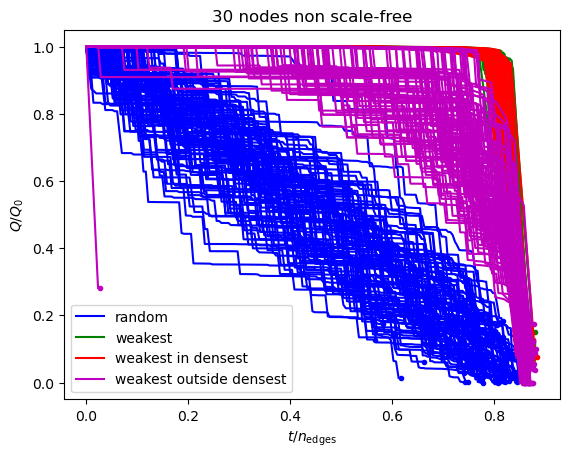

In [165]:
n=30
n_exp=100

graph_gen_type=gen_graph

i_max_list_random=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_random_edge(G)
    i_max_list_random[k]=i/loop_size
    plt.plot(i/loop_size,qs[i-1]/qs[0],'bo',markersize=3) 
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-',label='random')

i_max_list_weakest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_link(G,chosenedge)
        
    plt.plot(i/loop_size,qs[i-1]/qs[0],'go',markersize=3) 
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-')
    i_max_list_weakest[k]=i/loop_size
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-',label='weakest')


i_max_list_weakest_in_densest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_in_densest(G)
    i_max_list_weakest_in_densest[k]=i/loop_size
    plt.plot(i/loop_size,qs[i-1]/qs[0],'ro',markersize=3) 
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'r-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'r-',label='weakest in densest')

i_max_list_weakest_outside_densest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_outside_densest(G)
    i_max_list_weakest_outside_densest[k]=i/loop_size
    plt.plot(i/loop_size,qs[i-1]/qs[0],'mo',markersize=3) 
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'m-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'m-',label='weakest outside densest')

    
plt.ylabel('$Q/Q_0$');
plt.xlabel('$t/n_\mathrm{edges}$');
plt.legend(loc='lower left')
plt.title('30 nodes non scale-free')

plt.savefig("non-scale-free.pdf")

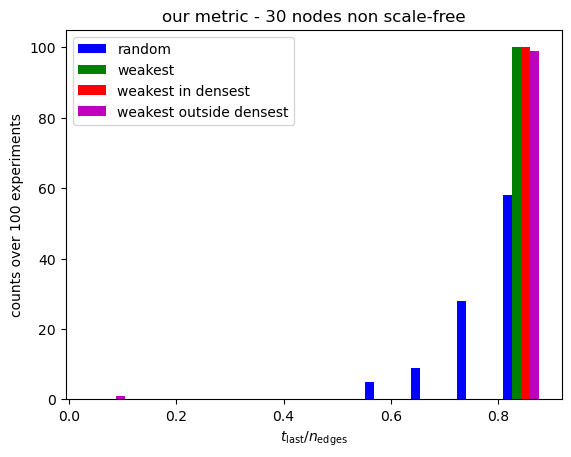

In [171]:
plt.hist([i_max_list_random,i_max_list_weakest,
          i_max_list_weakest_in_densest,i_max_list_weakest_outside_densest],
         bins=10,color=['b','g','r','m'], 
         label=['random','weakest','weakest in densest','weakest outside densest']);
plt.legend(loc='upper left')
plt.ylabel('counts over 100 experiments');
plt.xlabel('$t_\mathrm{last}/n_\mathrm{edges}$');
plt.title('our metric - 30 nodes non scale-free');
plt.savefig("metric-non-scale-free.pdf")

100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]


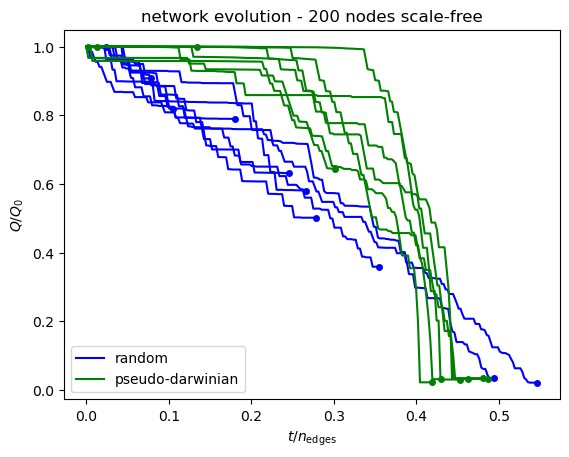

In [133]:
n=200
n_exp=10

graph_gen_type=gen_graph_scalefree

i_max_list_random=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_random_edge(G)
    i_max_list_random[k]=i/loop_size
    plt.plot(i/loop_size,qs[i-1]/qs[0],'bo',markersize=4)  
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-')
    
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-',label='random')
i_max_list_weakest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_link(G,chosenedge)
    plt.plot(i/loop_size,qs[i-1]/qs[0],'go',markersize=4)  
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-')
    i_max_list_weakest[k]=i/loop_size
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-',label='pseudo-darwinian')    
plt.ylabel('$Q/Q_0$');
plt.xlabel('$t/n_\mathrm{edges}$');
plt.legend(loc='lower left')
plt.title('network evolution - 200 nodes scale-free')

plt.savefig("random_vs_pseudodarwinian.pdf")

100%|█████████████████████████████████████████| 100/100 [09:31<00:00,  5.72s/it]


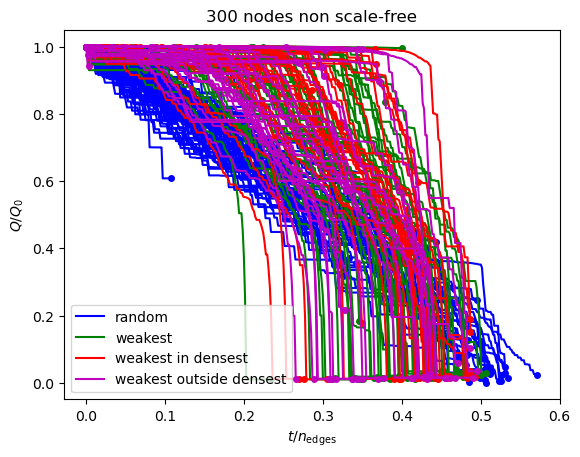

In [147]:
n=300
n_exp=100

graph_gen_type=gen_graph_scalefree

i_max_list_random=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_random_edge(G)
    i_max_list_random[k]=i/loop_size
    plt.plot((i-1)/loop_size,qs[i-1]/qs[0],'bo',markersize=4)
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'b-',label='random')


i_max_list_weakest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_link(G,chosenedge)
    plt.plot((i-1)/loop_size,qs[i-1]/qs[0],'go',markersize=4)
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-')
    i_max_list_weakest[k]=i/loop_size
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'g-',label='weakest')

i_max_list_weakest_in_densest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_in_densest(G)
    i_max_list_weakest_in_densest[k]=i/loop_size
    plt.plot((i-1)/loop_size,qs[i-1]/qs[0],'ro',markersize=4)
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'r-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'r-',label='weakest in densest')

    
i_max_list_weakest_outside_densest=np.zeros(n_exp)
for k in tqdm(range(n_exp)):

    G=graph_gen_type(n)
    loop_size = len(G.edges) 
    qs=np.empty(loop_size)
    qs[:]=np.nan

    for i in range(loop_size):
        try:
            q,chosenedge=get_Q(G)
            if i and q>qs[i-1]:
                break
            qs[i]=q
        except:
            break
        delete_weakest_outside_densest(G)
    i_max_list_weakest_outside_densest[k]=i/loop_size
    plt.plot((i-1)/loop_size,qs[i-1]/qs[0],'mo',markersize=4)
    plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'m-')
plt.plot(np.arange(i)/loop_size,qs[:i]/qs[0],'m-',label='weakest outside densest')


    
plt.ylabel('$Q/Q_0$');
plt.xlabel('$t/n_\mathrm{edges}$');
plt.legend(loc='lower left')
plt.title('300 nodes non scale-free')

plt.savefig("scale-free.pdf")

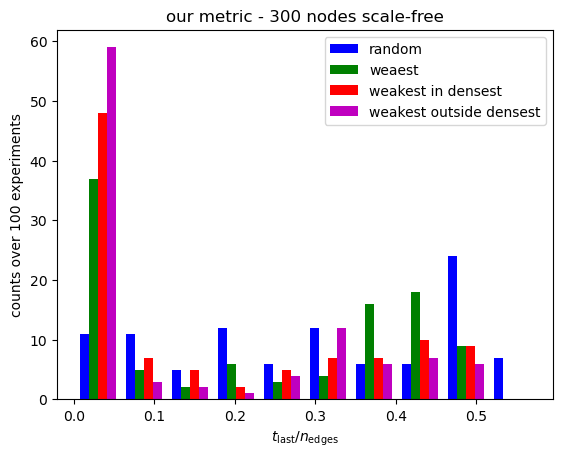

In [163]:
plt.hist([i_max_list_random,i_max_list_weakest,
          i_max_list_weakest_in_densest,i_max_list_weakest_outside_densest],
         bins=10,color=['b','g','r','m'], 
         label=['random','weaest','weakest in densest','weakest outside densest']);
plt.legend(loc='upper right')
plt.ylabel('counts over 100 experiments');
plt.xlabel('$t_\mathrm{last}/n_\mathrm{edges}$');
plt.title('our metric - 300 nodes scale-free');
plt.savefig("metric-scale-free.pdf")

(array([57.,  2.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  4.,  1.,  6.,
         6.,  4.,  1.,  2.,  3.,  4.,  4.]),
 array([0.00151515, 0.02631334, 0.05111154, 0.07590973, 0.10070792,
        0.12550611, 0.1503043 , 0.1751025 , 0.19990069, 0.22469888,
        0.24949707, 0.27429526, 0.29909346, 0.32389165, 0.34868984,
        0.37348803, 0.39828622, 0.42308442, 0.44788261, 0.4726808 ,
        0.49747899]),
 <BarContainer object of 20 artists>)

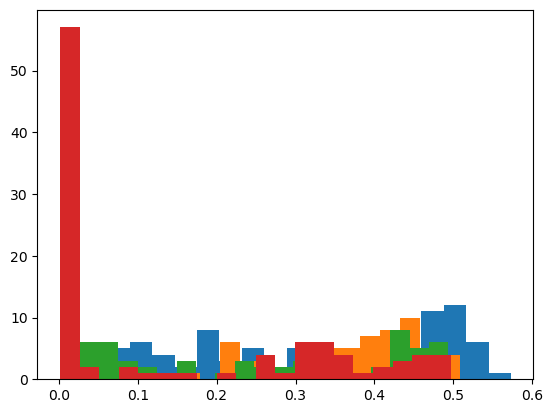

In [149]:
plt.hist(i_max_list_random,20)
plt.hist(i_max_list_weakest,20)
plt.hist(i_max_list_weakest_in_densest,20)
plt.hist(i_max_list_weakest_outside_densest,20)

In [77]:
print('random',np.mean(i_max_list_random))
print('weakest',np.mean(i_max_list_weakest))
print('weakest in densest',np.mean(i_max_list_weakest_in_densest))
print('weakest outside densest',np.mean(i_max_list_weakest_outside_densest))

random 0.5815478864588536
weakest 0.34250320549122687
weakest in densest 0.11603779950836064
weakest outside densest 0.22226550793375477


In [74]:
thres=10
print('random',np.mean(i_max_list_random[i_max_list_random>thres]))
print('weakest',np.mean(i_max_list_weakest[i_max_list_weakest>thres]))
print('weakest in densest',np.mean(i_max_list_weakest_in_densest[i_max_list_weakest_in_densest>thres]))
print('weakest outside densest',np.mean(i_max_list_weakest_outside_densest[i_max_list_weakest_outside_densest>thres]))

random 361.89473684210526
weakest 407.0
weakest in densest 160.58333333333334
weakest outside densest 186.84615384615384


In [28]:
G=gen_graph_scalefree(n)

In [30]:
G2=nx.Graph(G)
list(nx.k_edge_subgraphs(G2,k=3))


[{25},
 {18},
 {24},
 {38},
 {83},
 {36},
 {35},
 {39},
 {32},
 {30},
 {34},
 {27},
 {33},
 {37},
 {26},
 {8},
 {43},
 {42},
 {41},
 {44},
 {49},
 {46},
 {47},
 {48},
 {45},
 {50},
 {53},
 {54},
 {29},
 {51},
 {52},
 {60},
 {61},
 {58},
 {59},
 {55},
 {56},
 {62},
 {6},
 {63},
 {64},
 {65},
 {66},
 {67},
 {68},
 {40},
 {69},
 {70},
 {71},
 {72},
 {73},
 {17},
 {74},
 {75},
 {76},
 {77},
 {78},
 {79},
 {80},
 {81},
 {82},
 {3},
 {12},
 {84},
 {87},
 {88},
 {11},
 {85},
 {86},
 {93},
 {94},
 {91},
 {92},
 {89},
 {90},
 {95},
 {96},
 {97},
 {98},
 {99},
 {19},
 {23},
 {7},
 {0, 1, 2, 4, 5, 9, 10, 13, 14, 15, 16, 20, 21, 22, 28, 31, 57}]